# Tipificación de preguntas en GuessWhat?!

El dataset de [GuessWhat?!](https://arxiv.org/abs/1611.08481) es un dataset de diálogos visuales referenciales.
Está compuesto de diálogos contextualizados en imágenes basados en un juego de adivinar un objeto. Todas las preguntas son del estilo "Sí/No".

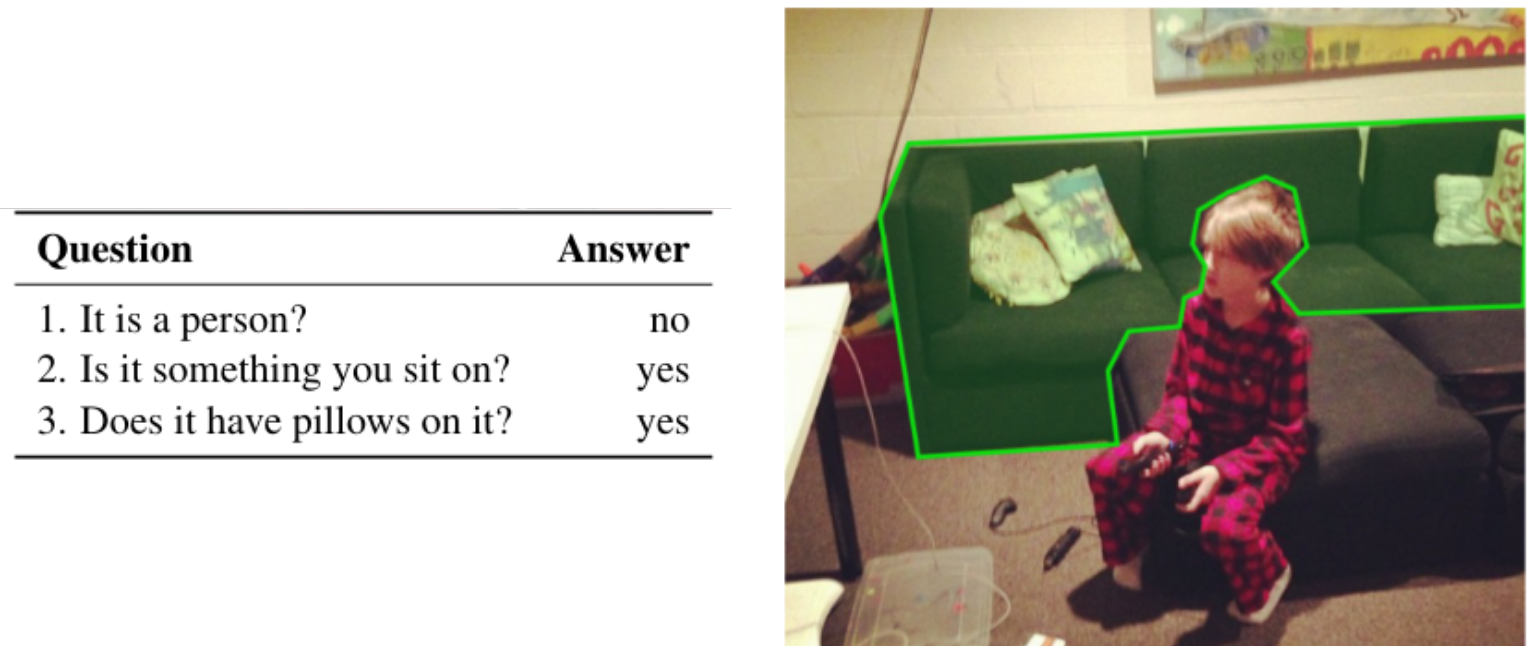

En este práctico voy a caracterizar las palabras usadas en distintas preguntas. El dataset se puede obtener [aquí](https://drive.google.com/file/d/1JiJIV_Ve65SHriU8veTtLVWmlM-Nu6pi/view?usp=sharing).

In [18]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# WordCloud
from wordcloud import WordCloud

# Sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# NLTK
from nltk.tokenize import TweetTokenizer

# PyPlot
import matplotlib.pyplot as plt

# Utils
import math
import jsonlines
import gzip
import os
import numpy as np
import json
from time import time
from tqdm import tqdm

In [2]:
rawdata = jsonlines.Reader(gzip.open('data/guesswhat.valid.jsonl.gz'))
questions = ""
for game in rawdata:
    for qa in game['qas']:
        questions += qa['question'].lower() + '\n'
        
fname = 'guesswhat.valid.raw.txt'
if not os.path.exists(fname):
    with open(fname, 'w') as fl:
        fl.write(questions)

# 1) Tipificación de preguntas en GuessWhat?!

Tipificar preguntas en el dataset de GuessWhat?! es necesario principalmente para fines de diagnóstico y análisis: conociendo en qué tipo de preguntas los modelos tienen problemas es que se puede guiar la investigación para entender las limitaciones y mejorar los modelos.

El previo script de clasificación tiene clasificaciones simples y útiles, pero es muy simple y por ende muchas veces genera clasificaciones erróneas.

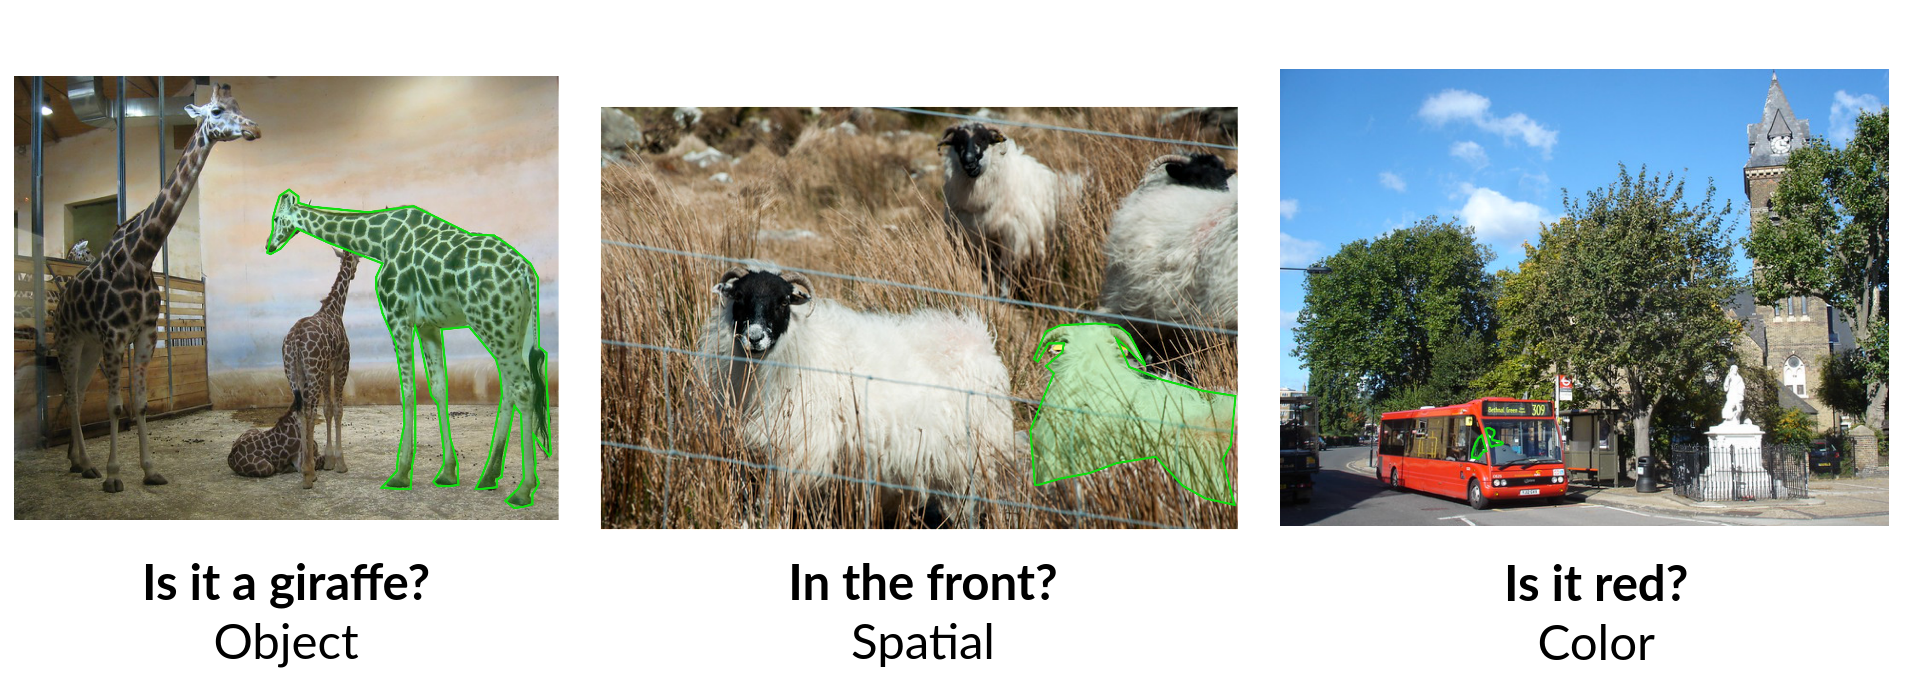

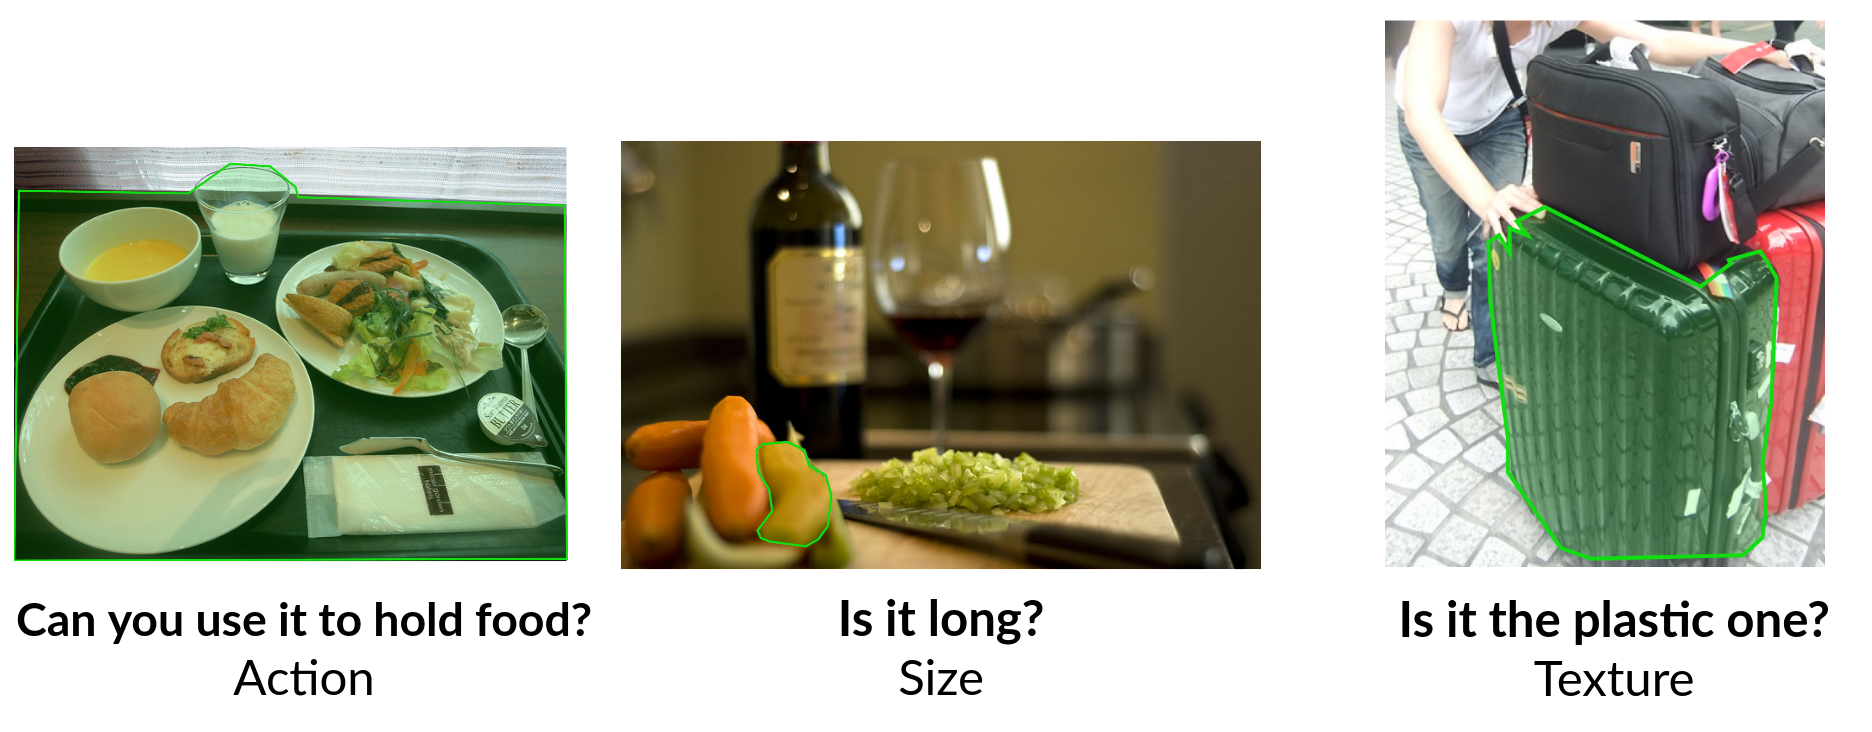

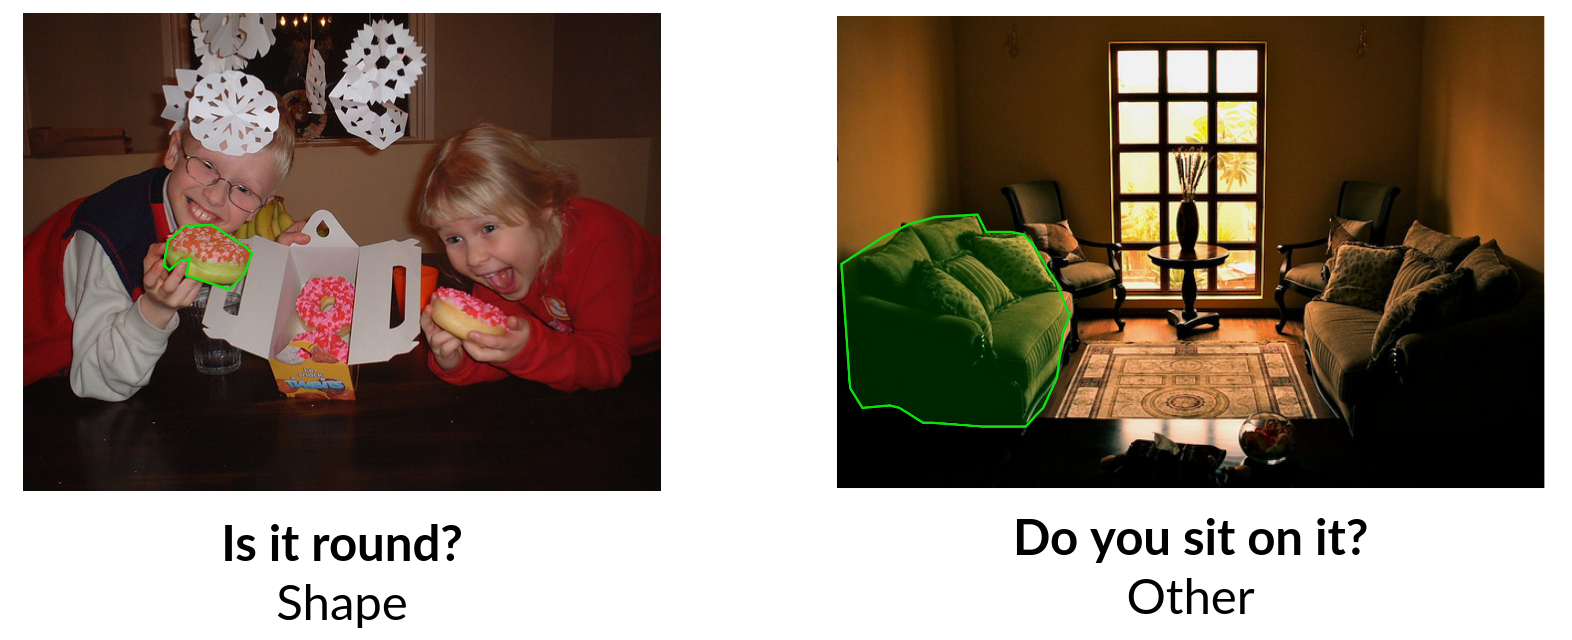

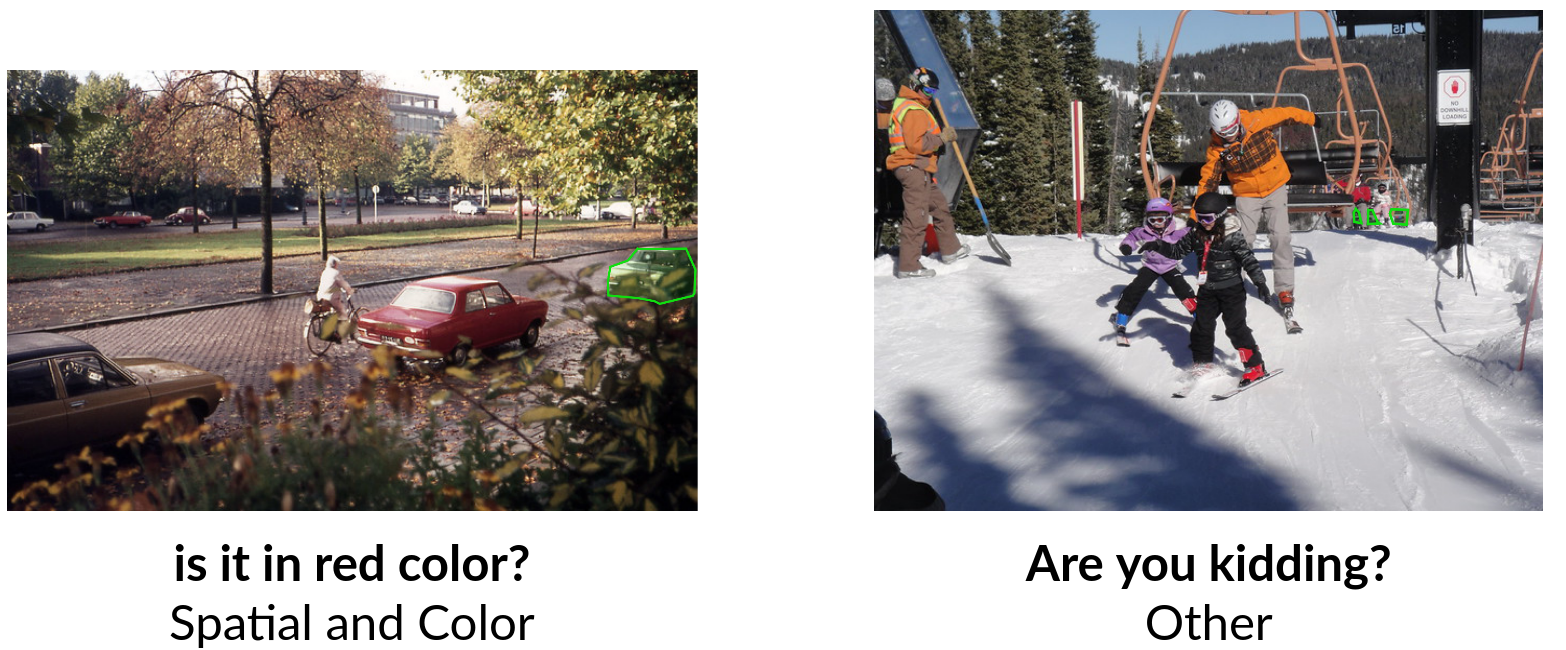

El principal objetivo es detectar distintos tipos de preguntas no contempladas en la clasificación previamente propuesta [(Shekhar et al., 2019)](https://aclanthology.org/N19-1265/) una clasificación más granular de las preguntas que luego puedan usarse para:
- entrenar un *Questioner* condicionado por tipo de pregunta
- usar las preguntas pertenecientes a cada cluster como dato de entrenamiento

## 2) Exploración Manual

Estoy trabajando con datos que ya fueron pasado a minúsculas. Todas las preguntas están aisladas

In [2]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')

print('Amount of questions: ', len(questions))

Amount of questions:  120319


In [3]:
questions = np.asarray(questions)
unique_questions = np.unique(questions)
print('Amount of unique questions: ', len(unique_questions))

Amount of unique questions:  52358


Miro la ocurrencia de palabras en el corpus original

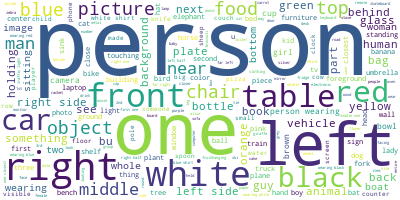

In [4]:
long_string = ','.join(questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

y en el corpus con solo preguntas únicas.

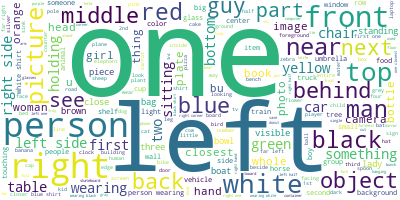

In [5]:
long_string = ','.join(unique_questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

## 3) Probar matriz de ocurrencia

Se usa TweetTokenizer ya que ambos son user generated text.

In [6]:
tokenizer = TweetTokenizer()

In [7]:
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
omatrix = vectorizer.fit_transform(unique_questions)

In [8]:
print('Count Vectorizer: ----')
print(len(vectorizer.get_feature_names()))
print(omatrix.toarray().shape)

Count Vectorizer: ----
5232
(52358, 5232)


In [9]:
feat_matrix = omatrix.toarray()

In [10]:
start = time()
norm_feat_matrix = normalize(feat_matrix)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(norm_feat_matrix)
print('Elapsed: ', time() - start)

Elapsed:  28.052268266677856


In [14]:
np.save('feats-unique_qs-countvec-50d-1SVD_iter.npy', reduced_feat_matrix)

In [11]:
reduced_feat_matrix = np.load('feats-unique_qs-countvec-50d-1SVD_iter.npy')

Clustering y extracción de distancias

In [13]:
NCLUSTERS = 20
model = KMeans(n_clusters=NCLUSTERS).fit(reduced_feat_matrix)
distances = model.transform(reduced_feat_matrix)
y_pred = model.labels_

In [ ]:
#start = time()
#embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)
#plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)
#print('Elapsed: ', time() - start)

Utils para visualización de clusters

In [24]:
def showing_cluster2(questions, clusters, distances, cluster_id, showing=50):
    showing_qs = []
    filtering = clusters == cluster_id
    data = {'question': questions[filtering], 'distance':distances[filtering][:,cluster_id]}
    data = pd.DataFrame(data).sort_values('distance')
    
    print(data.head(min(showing, len(data))))

In [23]:
for i in range(NCLUSTERS):
    print('Cluster', i)
    showing_cluster2(unique_questions, y_pred, distances, i, showing=10)
    print('---------------')

Cluster 0
                                               question  distance
243       is it closer to the kid than the older woman?  0.185876
254          is it closer to the tv than the fireplace?  0.196497
237            is it closer to the camera than the dog?  0.208475
786   is it the gray camel laying down that's closes...  0.209651
812      is it the kid about to be run over by the bus?  0.209767
1199             is it the third to the sixth broccoli?  0.210764
172              is it big compared to the other items?  0.211457
801               is it the handle to flush the toilet?  0.212145
1147                is it the seat closer to the train?  0.213856
231                    is it closer to me than the suv?  0.216748
---------------
Cluster 1
                                question  distance
855        totally 3 zebra facing right?  0.237126
324                m sorry...right most?  0.241904
521                 right leg ski board?  0.242782
486  right book case topmost shelf

## 4) Usar embeddings

Para esta parte usamos word embeddings de GLoVE con 50 dimensiones. GuessWhat?! tiene una alta cantidad de palabras desconocidas, por lo que necesitamos un embedding para palabras desconocidas.

In [25]:
PRETRAINED_EMBS = "glove.6B.50d.txt.gz"

In [30]:
embeddings_dict = {}
with gzip.open(PRETRAINED_EMBS, "rt") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [31]:
UNK_EMB = np.random.rand(50)

In [32]:
def preprocess_data(corpus, embeddings_dict):
    new_data = []
    vocab = []
    skipped = []
    for i, entry in enumerate(corpus):
        words = entry.strip().split()
        if len(words) < 1:
            print('WARNING: skipped empty question')
            skipped.append(i)
            continue
        # remove the last ? sign
        last = words[-1]
        words = words[:-1] + [last[:-1], '?']
        # append tokens to vocabulary
        vocab += words
        # form new data
        sent_embs = [embeddings_dict[w] if w in embeddings_dict.keys() else UNK_EMB for w in words]
        new_entry = np.array(sent_embs).sum(axis=0)
        new_data.append(new_entry)
    return np.array(new_data), skipped

In [33]:
agg_embs_sents, skipped = preprocess_data(unique_questions, embeddings_dict)

In [41]:
NCLUSTERS = 20
norm_feat_matrix = normalize(agg_embs_sents)
model = KMeans(n_clusters=NCLUSTERS).fit(norm_feat_matrix)
distances = model.transform(norm_feat_matrix)
y_pred = model.labels_

In [27]:
#start = time()
#embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(norm_feat_matrix)
#plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)
#print('Elapsed: ', time() - start)

In [42]:
for i in range(NCLUSTERS):
    print('Cluster', i)
    showing_cluster2(unique_questions[1:], y_pred, distances, i, showing=10)
    print('---------------')

Cluster 0
                                               question  distance
1573    is it the person in the red jacket behind them?  0.094396
1579  is it the person in the white shirt with the k...  0.095614
1646            is it the person with the white hat on?  0.098594
1670          is it the red and white one on the right?  0.102382
815               is it on the man with the blue shirt?  0.105184
1644               is it the person with the red shirt?  0.105942
749              is it left of the man with blue shirt?  0.107564
643                     is it black one behind the red?  0.107660
1490    is it the one with the guy with the blue shirt?  0.107843
1854   is it to the left of the kid in a striped shirt?  0.108554
---------------
Cluster 1
                              question  distance
367            can you look out of it?  0.082733
516          can you see out of it it?  0.095273
399          can you put things in it?  0.103088
636                can you turn it on?  0.

# 5) Mirar solo el conjunto de "Other"

Dado que los clusters no son del todo convincentes en el tipo de preguntas (muchos de ellos se agrupan simplemente por forma), podemos intentar explorar el subconjunto de preguntas que son clasificadas como "other".

In [43]:
fname = 'guesswhat.other.valid.raw.txt'
with open(fname) as fl:
    other_questions = fl.read().split('\n')

print('Amount of questions: ', len(other_questions))

other_questions = np.asarray(other_questions)
unique_other_questions = np.unique(other_questions)
print('Amount of unique questions: ', len(unique_other_questions))

Amount of questions:  9575
Amount of unique questions:  5317


In [56]:
agg_embs_sents2, skipped = preprocess_data(unique_other_questions, embeddings_dict)

In [57]:
skipped

[0]

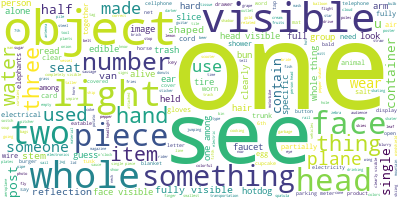

In [46]:
long_string = ','.join(unique_other_questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [64]:
NCLUSTERS = 10
norm_feat_matrix2 = normalize(agg_embs_sents2)
model_other = KMeans(n_clusters=NCLUSTERS).fit(norm_feat_matrix2)
distances2 = model_other.transform(norm_feat_matrix2)
y_pred2 = model_other.labels_

In [65]:
print(len(unique_other_questions))
print(len(y_pred2))
print(len(distances2))

5317
5316
5316


In [66]:
for i in range(NCLUSTERS):
    print('Cluster', i)
    showing_cluster2(unique_other_questions[1:], y_pred2, distances2, i, showing=30)
    print('---------------')

Cluster 0
                          question  distance
79              is it eightth one?  0.096380
109            is it stick-shaped?  0.119045
111             is it television'?  0.119045
110                 is it stissor?  0.119045
36                      is it 75%?  0.119045
82                   is it elepnt?  0.119045
100             is it santaclause?  0.119045
98             is it sand-colored?  0.119045
95              is it rectangluar?  0.119045
66                 is it backmost?  0.119045
67               is it batmintton?  0.119045
94                is it orangeish?  0.119045
91              is it monocolored?  0.119045
90                is it mid-right?  0.119045
72            is it chute/balloon?  0.119045
73                is it clear-ish?  0.119045
74                 is it cutlerry?  0.119045
86                 is it handwash?  0.119045
76                  is it eatable?  0.119045
85                  is it goldish?  0.119045
78                  is it edible??  0.119045
